In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from sympy import *

mpl.rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 20


%matplotlib inline

# Better looking figures
%config InlineBackend.figure_format = 'retina'

# Make cells narrower for better typography
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:65% !important; }</style>"))

init_printing(use_unicode=False, wrap_line=True)

# The Disturbing Function

We use the expansion developed in Mardling(2013), RM2013 for short. RM2013 develops two different expansions of the pertrubing part of the three body hamiltonian. The first expansion is in terms of spherical harmonics and is in principle exact in eccentricities and approximate in the ratio of semi-major axes. The second "principal" expansion is exact in the ratio of semi-major axes $\alpha=a_i/a_o$ and approximate in eccentricities, we use the first expansion here. The first expension has terms involving Hansen coefficients which are functions of the eccentricities and can in principle be calculated exactly. The expansion
uses Jacobi coordinates, symbols with subscript $i$ refere to the "inner binary" and those
with the subscript $o$ to the "outer binary".

The disturbing function has two parts, the secular part $\mathcal{R}_{sec}$ which doesn't depend on the fast varying longitudes and the resonant part $\mathcal{R}_{res}$. In our case, 
we neglect the secular part and concentrate on the single resonant term.

For the resonant part, we use only the dominant resonant (quadropole, i.e. $\propto\alpha^2$) term in case of the $n:1$ resonance. It is the term with $m=2$ in the RM2013 expansion.
Unfortunately there are no closed-form expressions for the Hansen coefficients and we can either calculate them numerically, or use a good enough series approximation, we opt for the latter. We can then write down the expression resonant part of the disturbing function.

The resonant part of the disturbing function for $m=2$ and $l=2$ is given by

$$\mathcal{R}_{res} = \frac{3}{4}\frac{G\mu_im_3}{a_o}\left(\frac{a_i}{a_o}\right)^2X^{2,2}_1(e_i)\,X^{-3,2}_{n'}(e_o)\cos(\lambda_i - n\lambda_o+\omega_i-(2-n)\omega_o)$$

Where $X^{2,2}_1(e_i)$ and $X^{-3,2}_{n'}(e_o)$ are Hansen coefficients which can be calculated as a series expansion in eccentricity to arbitrary order.

For reference, the secular part of the distrubing function to quadropole order is

$$\mathcal{R}_{sec} = \frac{G \mu_i a_{i}^{2} m_{3} \left(\frac{3 e_{i}^{2}}{2} + 1\right)}{4 a_{o}^{3} \left(- e_{o}^{2} + 1\right)^{\frac{3}{2}}}$$

## Calculating the Hansen coefficients

This is implemented in Mathematica because for some reason it can't be calculated in Sympy. Unfortunately, at this point we have to specify the order of the resonance because it is
not easy to calculate the Hansen coefficients for arbitrary $n$. 
For now, we choose $n=6$, which corresponds to a 6:1 resonance. The resulting 
coefficients are:

$$X^{2,2}_1(e_i) = -3e_i+\frac{13}{8}e_i^3+\frac{5}{192}e_i^5+\mathcal{O}(e_i^7)$$

$$X^{-3,2}_6(e_o)=\frac{533}{16}e_o^4-\frac{13827}{160}e_o^6+\frac{104127}{1280}e_o^8
+\mathcal{O}(e_i^{10})$$

We will use only the lowest order of each of the Hansen coefficients. To check for which values of $e$ is this justified, we plot the lowest order approximation and the "true" value of the coefficients.

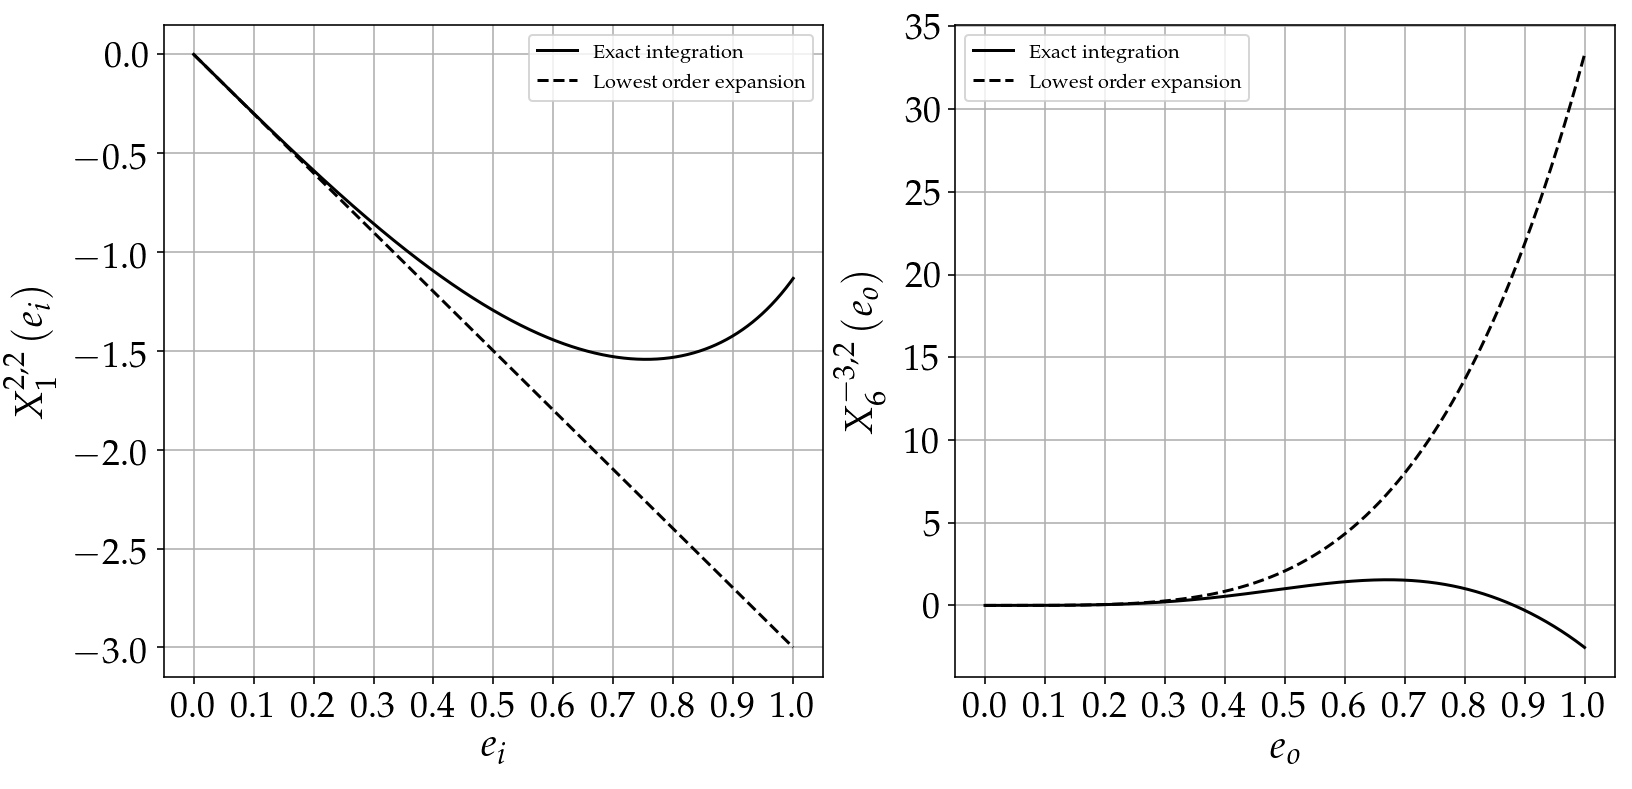

In [2]:
x_inner_approx = lambda a : -3*a
x_inner_true = lambda a : -3*a + (13*a**3)/8 + (5*a**5)/192 + (227*a**7)/3072 + (34349*a**9)/737280\
    + (2957173*a**11)/88473600 + (41963533*a**13)/1651507200\
    + (13410453149*a**15)/665887703040 + (15785824770269*a**17)/958878292377600
    
x_outer_true = lambda a : (533*a**4)/16 - (13827*a**6)/160 + (104127*a**8)/1280\
    - (146017*a**10)/3584 + (1832259*a**12)/143360 - (4045953*a**14)/1433600
x_outer_approx = lambda  a : (533*a**4)/16

e_ = np.linspace(0, 1, 1000)

fig, ax = plt.subplots(1, 2, figsize=(13,6))
ax[0].plot(e_, x_inner_true(e_), 'k', label='Exact integration')
ax[0].plot(e_, x_inner_approx(e_), 'k--', label='Lowest order expansion')
ax[0].set_xlabel(r'$e_i$')
ax[0].set_ylabel(r'$X^{2,2}_1\,(e_i)$')

ax[1].plot(e_, x_outer_true(e_), 'k', label='Exact integration')
ax[1].plot(e_, x_outer_approx(e_), 'k--', label='Lowest order expansion')
ax[1].set_xlabel(r'$e_o$')
ax[1].set_ylabel(r'$X^{-3,2}_6\,(e_o)$')

for a in ax.ravel():
    a.grid(True)
    a.set_xticks(np.linspace(0,1,11))
    a.legend()

# plt.savefig('../figures/analytical_model/hansec_oefficients.pdf', bbox_inches='tight')

As we can see the figure, the lowest order approximation is justifiable only for low eccentricities, $e_i\lesssim 0.3$ and $e_o \lesssim 0.4$. Therefore, the whole subsequent analysis of the 6:1 resonance is valid only in this regime.

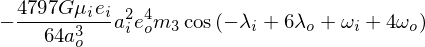

In [3]:
# Define symbols for orbital elements and constants
mu_i, mu_o, a_i, a_o, e_i, e_o, m3, n, G = \
symbols("\mu_i \mu_o a_i a_o e_i e_o m_3 n G", positive=True, real=True)
    
lambda_i, lambda_o, w_i, w_o = \
    symbols("\lambda_i, \lambda_o, \omega_i, \omega_o", real=True)

    
# Define Hensen coefficients for n=6    
x_in = -3*e_i #+ 13*e_i**3/8 + 5*e_i**5/192
x_ou = 533*e_o**4/16 # - 13827*e_o**6/160 + 104127*e_o**8/1280

# Resonant part of the disturbing function
R = Rational(3,4)*G*mu_i*m3/a_o*(a_i/a_o)**2*x_in*x_ou\
*cos(6*lambda_o - lambda_i +4*w_o + w_i)
R

The resonant part has a leading term of order $e_ie_o^4$.

# Poincaré variables

Poincaré variables for the inner binary are defined as:

$$\lambda_i = \lambda_i,\quad \Lambda_i = \mu_i \sqrt{G m_{12} a_i} $$
$$\gamma_i = -\omega_i,\quad \Gamma_i = \mu_i \sqrt{G m_{12} a_i} (1-\sqrt{1-e_i^2})$$

Similarly, for the outer binary:

$$\lambda_o = \lambda_o,\quad \Lambda_o = \mu_o \sqrt{G m_{123} a_o}$$
$$\gamma_o = -\omega_o,\quad \Gamma_o = \mu_o \sqrt{G m_{123} a_o} (1-\sqrt{1-e_o^2})$$

We can solve the above system to obtain the expression for the orbital elements expressed in terms of Poincaré momenta. Since the new coordinates and momenta are functions of both the previous momenta and the coordinates,  it is known from the literature that this transformation is canonical.

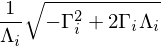

In [4]:
# Define Poincaré variables
Lambda_i, Gamma_i, Lambda_o, Gamma_o, m12, m123 =\
    symbols("\Lambda_i, Gamma_i, \Lambda_o, Gamma_o, m_{12}, m_{123}",
              real=True, positive=True)  
gamma_o, gamma_i = symbols("\gamma_o, \gamma_i", real=True)
    
# Solve for orbital elements in terms of Poincaré variables
sol = solve([Eq(mu_i*sqrt(G*m12*a_i) - Lambda_i),
           Eq(mu_i*sqrt(G*m12*a_i)*(1 - sqrt(1 - e_i**2)) - Gamma_i)],
        [a_i, e_i])

expand(simplify(sol[1][1]))

The second solution is phyiscally meaningful because $e$ is defined to be positive. 
Therefore, the orbital elements in terms of Poincare coordinates are given by:

$$a_i = \frac{\Lambda_i^{2}}{G \mu_i^{2} m_{12}}\quad e_i = \frac{1}{\Lambda_i} \sqrt{\Lambda_i^{2} - \left(\Gamma_{i} - \Lambda_i\right)^{2}}$$

and for the outer part:

$$a_o = \frac{\Lambda_o^{2}}{G \mu_o^{2} m_{123}}\quad e_o = \frac{1}{\Lambda_o} \sqrt{\Lambda_o^{2} - \left(\Gamma_{o} - \Lambda_o\right)^{2}}$$

we can now write the Disturbing function in Poincaré variables:

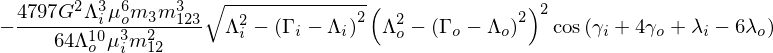

In [5]:
# Disturbing function in Poincaré coordinates
R = R.subs({a_i: Lambda_i**2/(G*mu_i**2*m12),
            e_i: sqrt(Lambda_i**2 - (Gamma_i - Lambda_i)**2)/Lambda_i,
            a_o: Lambda_o**2/(G*mu_o**2*m123),
            e_o: sqrt(Lambda_o**2 - (Gamma_o - Lambda_o)**2)/Lambda_o,
            w_i: -gamma_i,
            w_o: -gamma_o})
R

# The complete Hamiltonian 

## Keplerian terms

The complete Hamiltonian of the three body system is given by 

$$\mathcal{H}=\mathcal{H}_{kepler}-\mathcal{R}$$

where $\mathcal{H}_{kepler}$ is the Keplerian part.

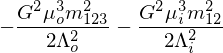

In [6]:
# Define Keplerian hamiltonian in Poincaré coordinates
H_k = - G**2*m12**2*mu_i**3/(2*Lambda_i**2) - G**2*m123**2*mu_o**3/(2*Lambda_o**2)
H_k

$$\mathcal{H}_{Kepler}=- \frac{G^{2} \mu_o^{3} m_{123}^{2}}{2 \Lambda_o^{2}} - \frac{G^{2} \mu_i^{3} m_{12}^{2}}{2 \Lambda_i^{2}}$$

Since we're interested in behaviour close to resonance, we can expanded the Keplerian Hamiltonain in a series around a $\Lambda$ wchich corresponds to exact resonance, we denote this value of $\Lambda$ as $\tilde{\Lambda}$.

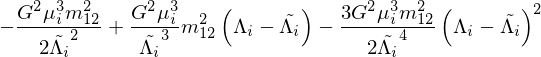

In [7]:
LLambda_o, LLambda_i  =\
symbols(r"\tilde{\Lambda_o}, \tilde{\Lambda_i}", real=True, positive=True)

series(H_k.args[0], Lambda_i, LLambda_i, 3).removeO()

We define new momenta $J_1=\Lambda_i - \tilde{\Lambda_i}$ and 
$J_2=\Lambda_o - \tilde{\Lambda_o}$. The keplerian Hamiltonian is then given by

$$\mathcal{H}_{K}=\frac{G^2 \mu_i^3 m_{12}^2}{2\tilde{\Lambda_i}^3}J_1 -\frac{3 G^2 \mu_i^3 m_{12}^2}{2\tilde{\Lambda_i}^4}J_1^2+ \frac{G^2 \mu_o^3 m_{123}^2}{2\tilde{\Lambda_o}^3}J_2 -\frac{3 G^2 \mu_o^3 m_{123}^2}{2\tilde{\Lambda_o}^4}J_2^2 + const.$$

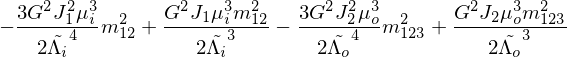

In [8]:
J1, J2 = symbols(r"J_1 J_2", real=True)

ci = G**2*mu_i**3*m12**2
co = G**2*mu_o**3*m123**2

# Expanded Keplerian Hamiltonian
H_kexp = ci*J1/(2*LLambda_i**3) + co*J2/(2*LLambda_o**3) -3*ci*J1**2/(2*LLambda_i**4)\
    -3*co*J2**2/(2*LLambda_o**4)
H_kexp

## Resonant term

We expand the resonant part of the hamiltonian to lowest order in $\Gamma_i$ and 
$\Gamma_o$ and to order 0 in $\Lambda-\widetilde{\Lambda}$. The resulting function is proportional to

$$\mathcal{R}\propto \sqrt{\Gamma_i}{\Gamma_o^2} + \mathcal{O}(\Gamma_i, \Gamma_o^3)$$

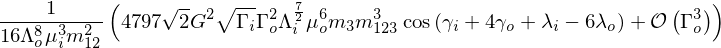

In [9]:
H_res = -R

simplify(series(series(H_res, Gamma_i, 0, 1).removeO(), Gamma_o, 0, 3))

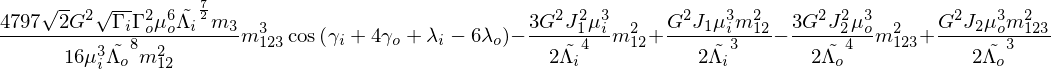

In [10]:
H_res = series(series(H_res, Gamma_i, 0, 1).removeO(), Gamma_o, 0, 3).removeO()
simplify(H_res)
H_res = H_res.subs({
    Lambda_i: LLambda_i,
    Lambda_o: LLambda_o
})

H = H_res + H_kexp
H

## Nondimensionalization

Now that we have the complete Hamiltonian, it is useful to remove physical units.
We proceed by rescaling all masses by a factor $m'$, lengths by factor $a'$.
G is factorized out of the definitions of Poincaré and $J_1$ and
$J_2$ momenta. 

$$\hat{m}_{12}=\frac{m_{12}}{m'}\quad \hat{m}_{123}=\frac{m_{123}}{m'}
\quad \hat{a}_{i}=\frac{a_{i}}{a'}\quad\hat{a}_{o}=\frac{a_{o}}{a'}\quad$$


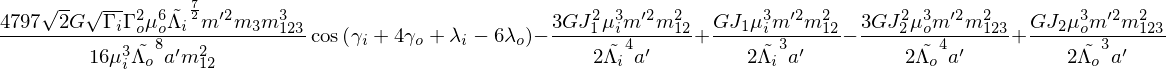

In [11]:
m, a = symbols("m' a'", positive=True)
H = H.subs({
    J1: m*sqrt(G*a*m)*J1,
    J2: m*sqrt(G*a*m)*J2,
    Gamma_i: m*sqrt(G*a*m)*Gamma_i,
    Gamma_o: m*sqrt(G*a*m)*Gamma_o,
    LLambda_i: m*sqrt(G*a*m)*LLambda_i,
    LLambda_o: m*sqrt(G*a*m)*LLambda_o,
    mu_i: m*mu_i,
    mu_o: m*mu_o,
    m12: m*m12,
    m123: m*m123,
    m3: m*m3
})
H

Next, we multiply the Hamiltonian by $a/(M^2G)$ which makes it dimensionless.We put mass in units of the inner binary
mass, length in units of the inner binary semi-major axis at exact resonance, 
and time in units of the inner
binary inverse mean motion.

$$m'=m_{12}\quad a'=\tilde{a_i}$$

therefore, we have $m_{12}$=1, $m_{123}\approx m_{12}=1$ and $\mu_o\approx m_3$.

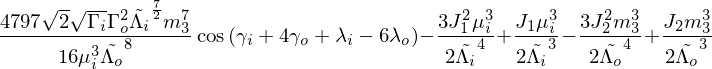

In [12]:
H = H.subs({
    mu_o: m3,
    m12: 1,
    m123: 1,
})
H = H*a/(G*m**2)
simplify(H)

# Reduction to a single degree of freedom

In order to reduce the above Hamiltonian to a single degree of freedom, we make use of a canonical transformation which uses the harmonic angle as one of the new conjugate positions. The transformation is of the form:

$$(\lambda_i, \lambda_o,\gamma_i, \gamma_o, J_1, J_2, \Gamma_i, \Gamma_o)
\rightarrow(\theta_1, \theta_2, \theta_3, \theta_4, \Theta_1, \Theta_2, \Theta_3, \Theta_4)$$

it is generated by the generating function of the 2nd type defined below.

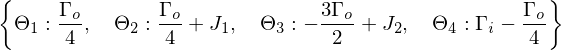

In [13]:
# Define new coordinates and momenta
t1, t2, t3, t4, T1, T2, T3, T4 =\
symbols(r"\theta_1, \theta_2, \theta_3, \theta_4, \Theta_1, \Theta_2, \Theta_3, \Theta_4",
        real=True)

# Specify F2
F2 = (-lambda_i + 6*lambda_o + gamma_i + 4*gamma_o)*T1 + lambda_i*T2 + lambda_o*T3\
    + gamma_i*T4

H = H.subs({
    J1: diff(F2, lambda_i),
    J2: diff(F2, lambda_o),
    Gamma_i: diff(F2, gamma_i),
    Gamma_o: diff(F2, gamma_o),
    gamma_i: t1 -(4*gamma_o + lambda_i - 6*lambda_o)
})

# Solve for new momenta in terms of old momenta
sol = solve([
    Eq(diff(F2, lambda_i) - J1),
    Eq(diff(F2, lambda_o) - J2),
    Eq(diff(F2, gamma_i) - Gamma_i),
    Eq(diff(F2, gamma_o) - Gamma_o)], [T1, T2, T3 ,T4])
sol

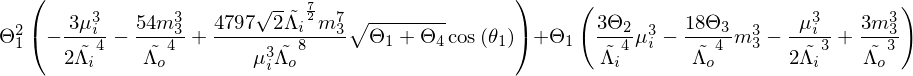

In [14]:
H = collect(expand(H), T1 ).args[0] + collect(expand(H), T1).args[1]
H

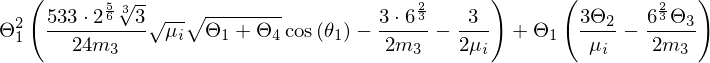

In [15]:
m1, m2 = symbols(r'm_1 m_2', positive=True)
H.subs({
    LLambda_i: mu_i,
    LLambda_o: m3*6**Rational(1,3),
})

In [16]:
Theta, theta, delta = symbols('\Theta theta  \delta', real=True)
c = symbols(r'c', real=True, positive=True)
ham = Theta**2 - delta*Theta + Theta**2*sqrt(Theta + c)*cos(theta)
ham

## Fixed points and phase space plots

In [17]:
diff(ham, theta)

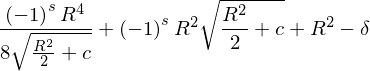

In [18]:
s, R = symbols('s R', positive=True)
fixed_points = diff(ham, Theta).subs({
    cos(theta):(-1)**s,
    Theta: R**2/2
})
fixed_points

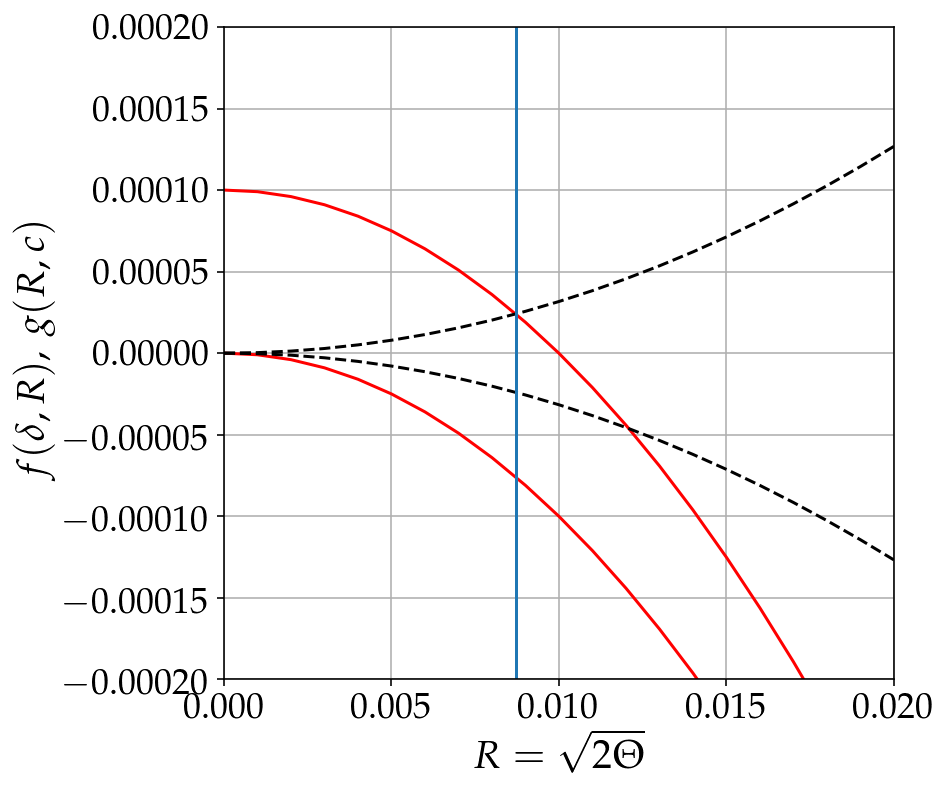

In [19]:
nR = np.linspace(0, 2., 2000)

f = lambda delta, R: delta - R**2
g = lambda R, c, s: s*((R**4/(8*np.sqrt(0.5*R**2 + c)))\
    + R**2*np.sqrt(0.5*R**2 + c))

fig, a = plt.subplots(figsize=(6,6))

a.set_xlim(0, 0.02)
a.set_ylim(-0.0002, 0.0002)
a.set_xlabel(r"$R=\sqrt{2\Theta}$")
a.grid(True)

c = 0.1
for d in np.linspace(-0.01, 0.05, 15):
    if(d != 0):
        a.plot(nR, f(d, nR), 'k-')
a.plot(nR, f(0, nR), color='red')
a.plot(nR, f(0.0001, nR), color='red')
a.plot(nR, g(nR, c, 1), 'k--')
a.plot(nR, g(nR, c, -1), 'k--')
a.set_ylabel(r"$f(\delta,R),\,g(R,c)$")
a.axvline(x=0.00871604805048)

# plt.savefig('../figures/analytical_model/fixed_points.pdf', bbox_inches='tight')

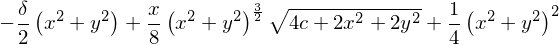

In [20]:
x, y = symbols('x y', real=True)

ham_cart = simplify(ham.subs({
    Theta: (x**2+y**2)/2,
    cos(theta): x/sqrt(x**2+y**2)}))
ham_cart

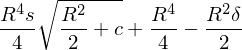

In [21]:
ham.subs({
    cos(theta):s,
    Theta: R**2/2
})

### Find roots numerically

In [22]:
H_R = lambda R, delta, c, s: -s*R**4*np.sqrt(R**2/2 + c)/4 + R**4/4 - R**2*delta/2
H_cart = lambda X, Y, delta, c: -delta*(X**2 + Y**2)/2 + X*(X**2 + Y**2)**(3/2.)\
    *np.sqrt(4*c +2*X**2 + 2*Y**2)/8 + (X**2 + Y**2)**2/4

In [23]:
#Find roots numerically
from scipy.optimize import fsolve

def function(R, *args):
    delta_, c_ , s_ = args
    return delta_ - R**2 + s_*((R**4/(8*np.sqrt(0.5*R**2 + c_)))\
        + R**2*np.sqrt(0.5*R**2 + c_))
    
def find_fixed_points(delta_, c_, s_):
    result = fsolve(function, 0.01, (delta_, c_, s_))
    return result[0]

delta_ = 0.0001
c_ = 0.1

saddle = find_fixed_points(delta_, c_, -1)
center = find_fixed_points(delta_, c_, 1)
H_saddle = H_R(saddle, delta_, c_, -1)
print(H_saddle)

-1.89928066014e-09


### Morphogenesis

/home/fran/anaconda3/lib/python3.5/site-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The number of calls to function has reached maxfev = 400.
  warnings.warn(msg, RuntimeWarning)


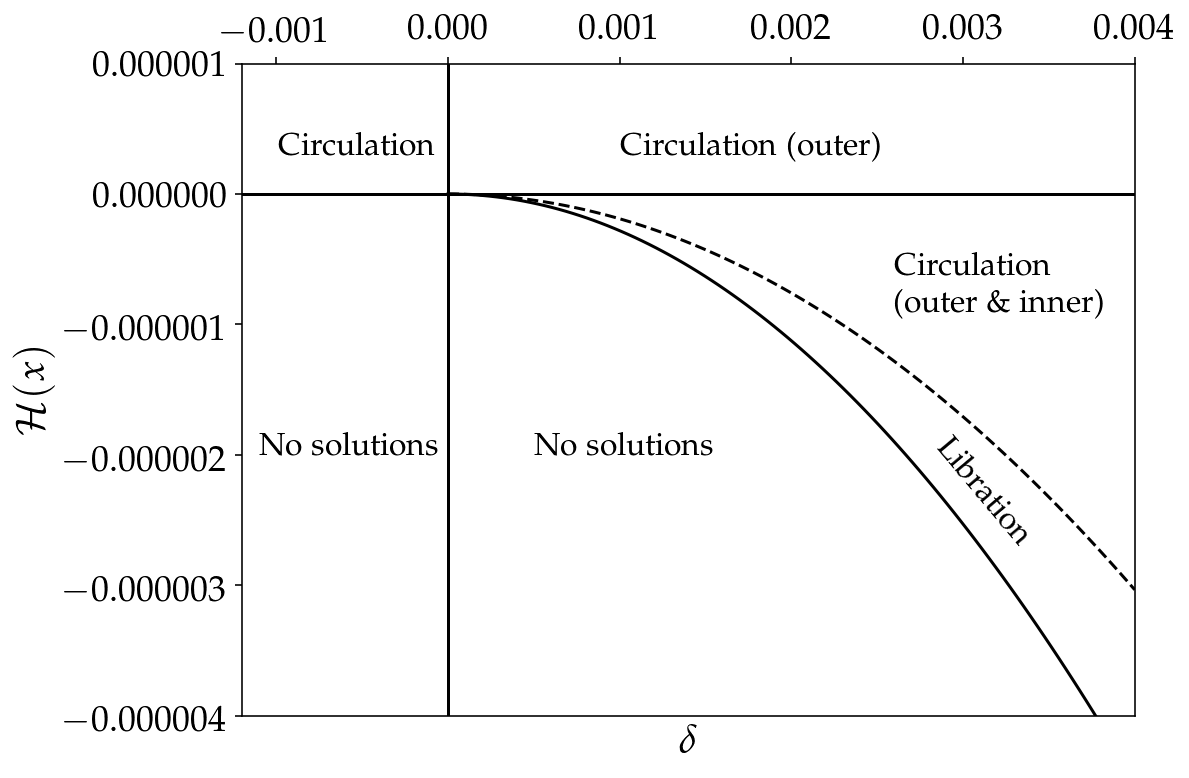

In [24]:
delta_array = np.linspace(0, 0.004, 100)
saddles = np.zeros(100)
centers = np.zeros(100)

for i, d in enumerate(delta_array):
    tmp_saddle = find_fixed_points(d, c_, -1)
    tmp_H_saddle = H_R(tmp_saddle, d, c_, -1)
    tmp_center = find_fixed_points(d, c_, 1)
    tmp_H_center = H_R(tmp_saddle, d, c_, 1)
    saddles[i] = tmp_H_saddle
    centers[i] = tmp_H_center
    
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(delta_array, centers, 'k')
ax.plot(delta_array, saddles, 'k--')
# ax.grid(True5
ax.set_xlim(-0.0012, 0.004)
ax.set_ylim(-0.000004, 0.000001)
ax.xaxis.tick_top()
ax.axhline(0, color='k')
ax.axvline(0, color='k')
ax.text(0.0028, -0.000002, 'Libration', fontsize=16, rotation=-50)
ax.text(2.6*1e-03, -0.09*1e-05, 'Circulation\n(outer \& inner)', fontsize=16)
ax.text(0.5*1e-03, -2*1e-06, 'No solutions', fontsize=16)
ax.text(-1.1*1e-03, -2*1e-06, 'No solutions', fontsize=16)
ax.text(-0.99*1e-03, 0.3*1e-06, 'Circulation', fontsize=16)
ax.text(1*1e-03, 0.3*1e-06, 'Circulation (outer)', fontsize=16)
ax.set_xlabel(r'$\delta$')
ax.set_ylabel(r'$\mathcal{H}(x)$')
plt.savefig('../figures/analytical_model/morpogenesis.pdf', bbox_inches='tight')

### Phase space plots

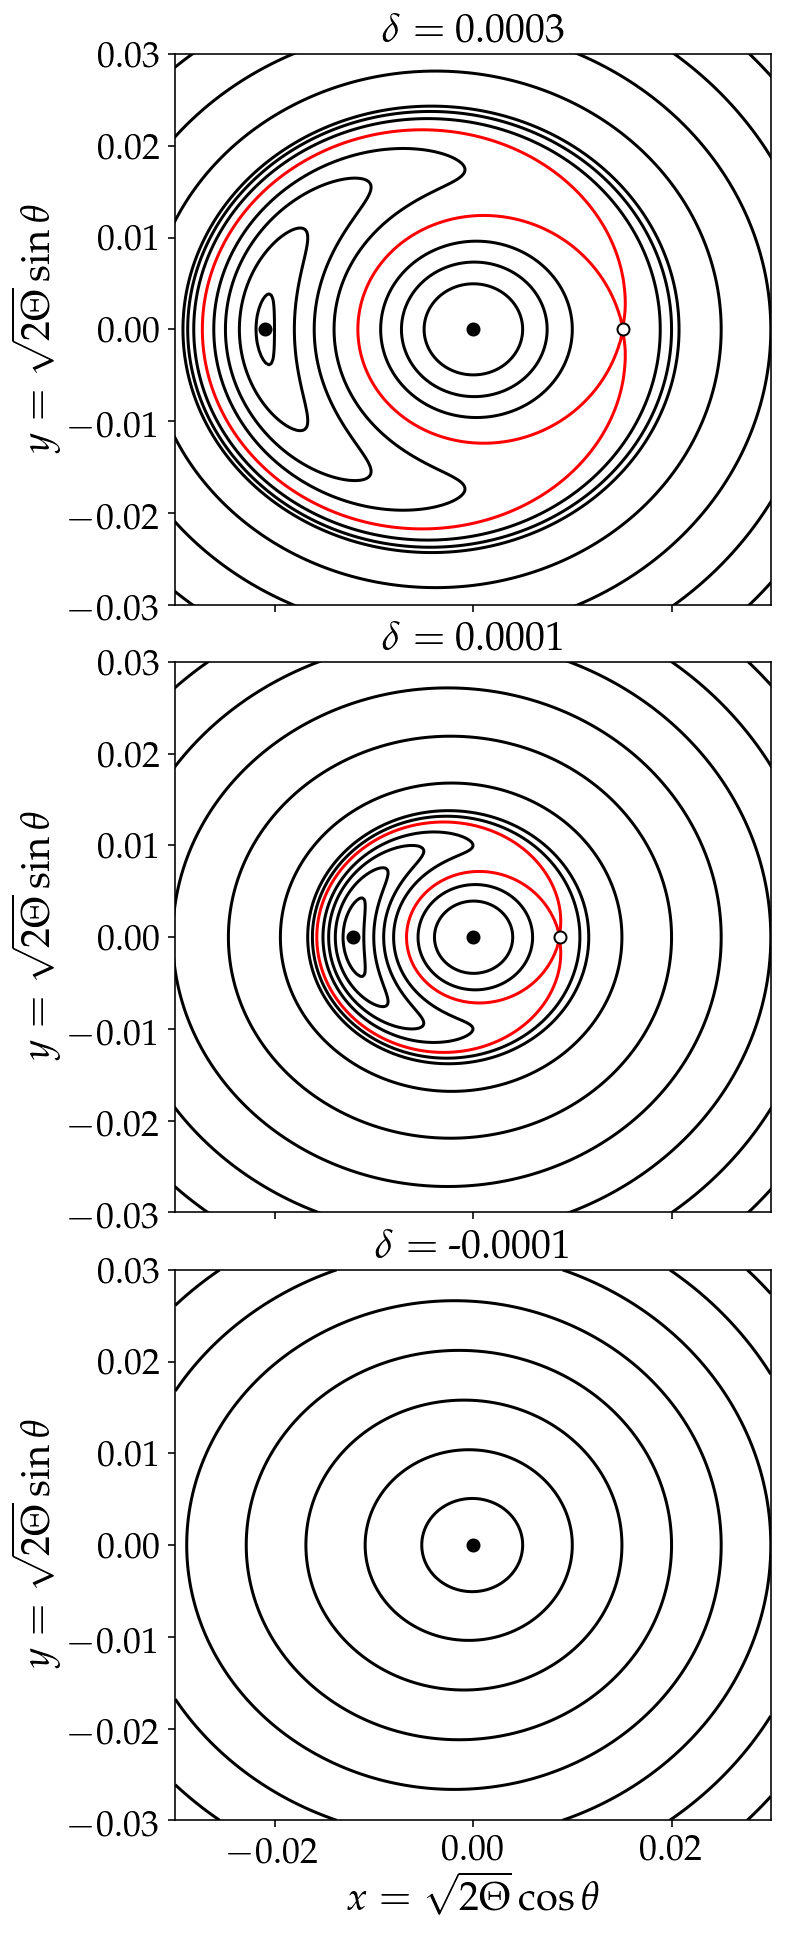

In [25]:
def plot_hamiltonian(ax, delta_, c_, lvls):      
    """
    Calculate the Hamiltonian as a function of x and y coordinates, defined
    as x=sqrt(2*Phi)*cos(phi), y=sqrt(2*Phi)*sin(phi)
    """      
    if(delta_ > 0):
        # Define (x,y) grid
        l = 0.05
        x_ = np.linspace(-l, l, 500)
        y_ = np.linspace(-l, l, 500)
        X, Y = np.meshgrid(x_, y_)
        
        saddle = find_fixed_points(delta_, c_, -1)
        center = find_fixed_points(delta_, c_, 1)
        H_saddle = H_R(saddle, delta_, c_, -1)
        H_center = H_R(center, delta_, c_, 1)


        separatrix = ax.contour(X, Y, H_cart(X,Y, delta_, c_), levels=[H_saddle], colors='red',zorder=1)
        for line in separatrix.collections:
            line.set_linestyle('solid')      
        
        contour = ax.contour(X, Y, H_cart(X,Y, delta_, c_), levels=lvls, colors='black')

        for line in contour.collections:
            line.set_linestyle('solid')

        # Plot the fixed points
        x_centers = [-center, 0]
        y_centers = np.zeros(2)
        x_saddle = saddle
        y_saddle = 0

        ax.scatter(x_centers, y_centers, color='black')
        ax.scatter(x_saddle, y_saddle, facecolor='white', edgecolor='black', zorder=2)
        ax.set_title("$\delta =$ {0}".format(delta_))
        
    else:
        # Define (x,y) grid
        l = 0.03
        x_ = np.linspace(-l, l, 500)
        y_ = np.linspace(-l, l, 500)
        X, Y = np.meshgrid(x_, y_)
                
        contour = ax.contour(X, Y, H_cart(X, Y, delta_, c_), levels=lvls, colors='black')
        
        # Plot the fixed points
        ax.scatter(0, 0, color='black')
        ax.set_title("$\delta =$ {0}".format(delta_))


x_value = np.array([0.025, 0.03, 0.04, 0.05, 0.035, 0.01, 0.02,
                 0.005,-0.014, -0.016, -0.018, -0.02])

x_value2 = np.array([0.05, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 
                     0.006, 0.004, -0.008, -0.009, -0.01, -0.011])
x_value3 = np.array([0.05, 0.045, 0.04, 0.035, 0.03, 0.02, 0.025, 0.015,
                    0.01, 0.005])


lvls = np.sort(H_cart(x_value, 0, 3e-04, 0.1))
lvls2 = np.sort(H_cart(x_value2, 0, 1e-04, 0.1))
lvls3 = np.sort(H_cart(x_value3, 0, -1e-04, 0.1))

fig, ax = plt.subplots(3, 1, sharex=True, figsize=(5, 13))
fig.tight_layout()
plot_hamiltonian(ax[0], 3e-04, 0.1, lvls)
plot_hamiltonian(ax[1], 1e-04, 0.1, lvls2)
plot_hamiltonian(ax[2], -1e-04, 0.1, lvls3)

for a in ax.ravel():
    a.set_ylabel(r'$y=\sqrt{2\Theta}\sin\theta$')
    a.set_xlim(-0.03, 0.03)
    a.set_ylim(-0.03, 0.03)

ax[2].set_xlabel(r'$x=\sqrt{2\Theta}\cos\theta$')
# plt.savefig('../figures/analytical_model/phase_space_plot.pdf', bbox_inches='tight')

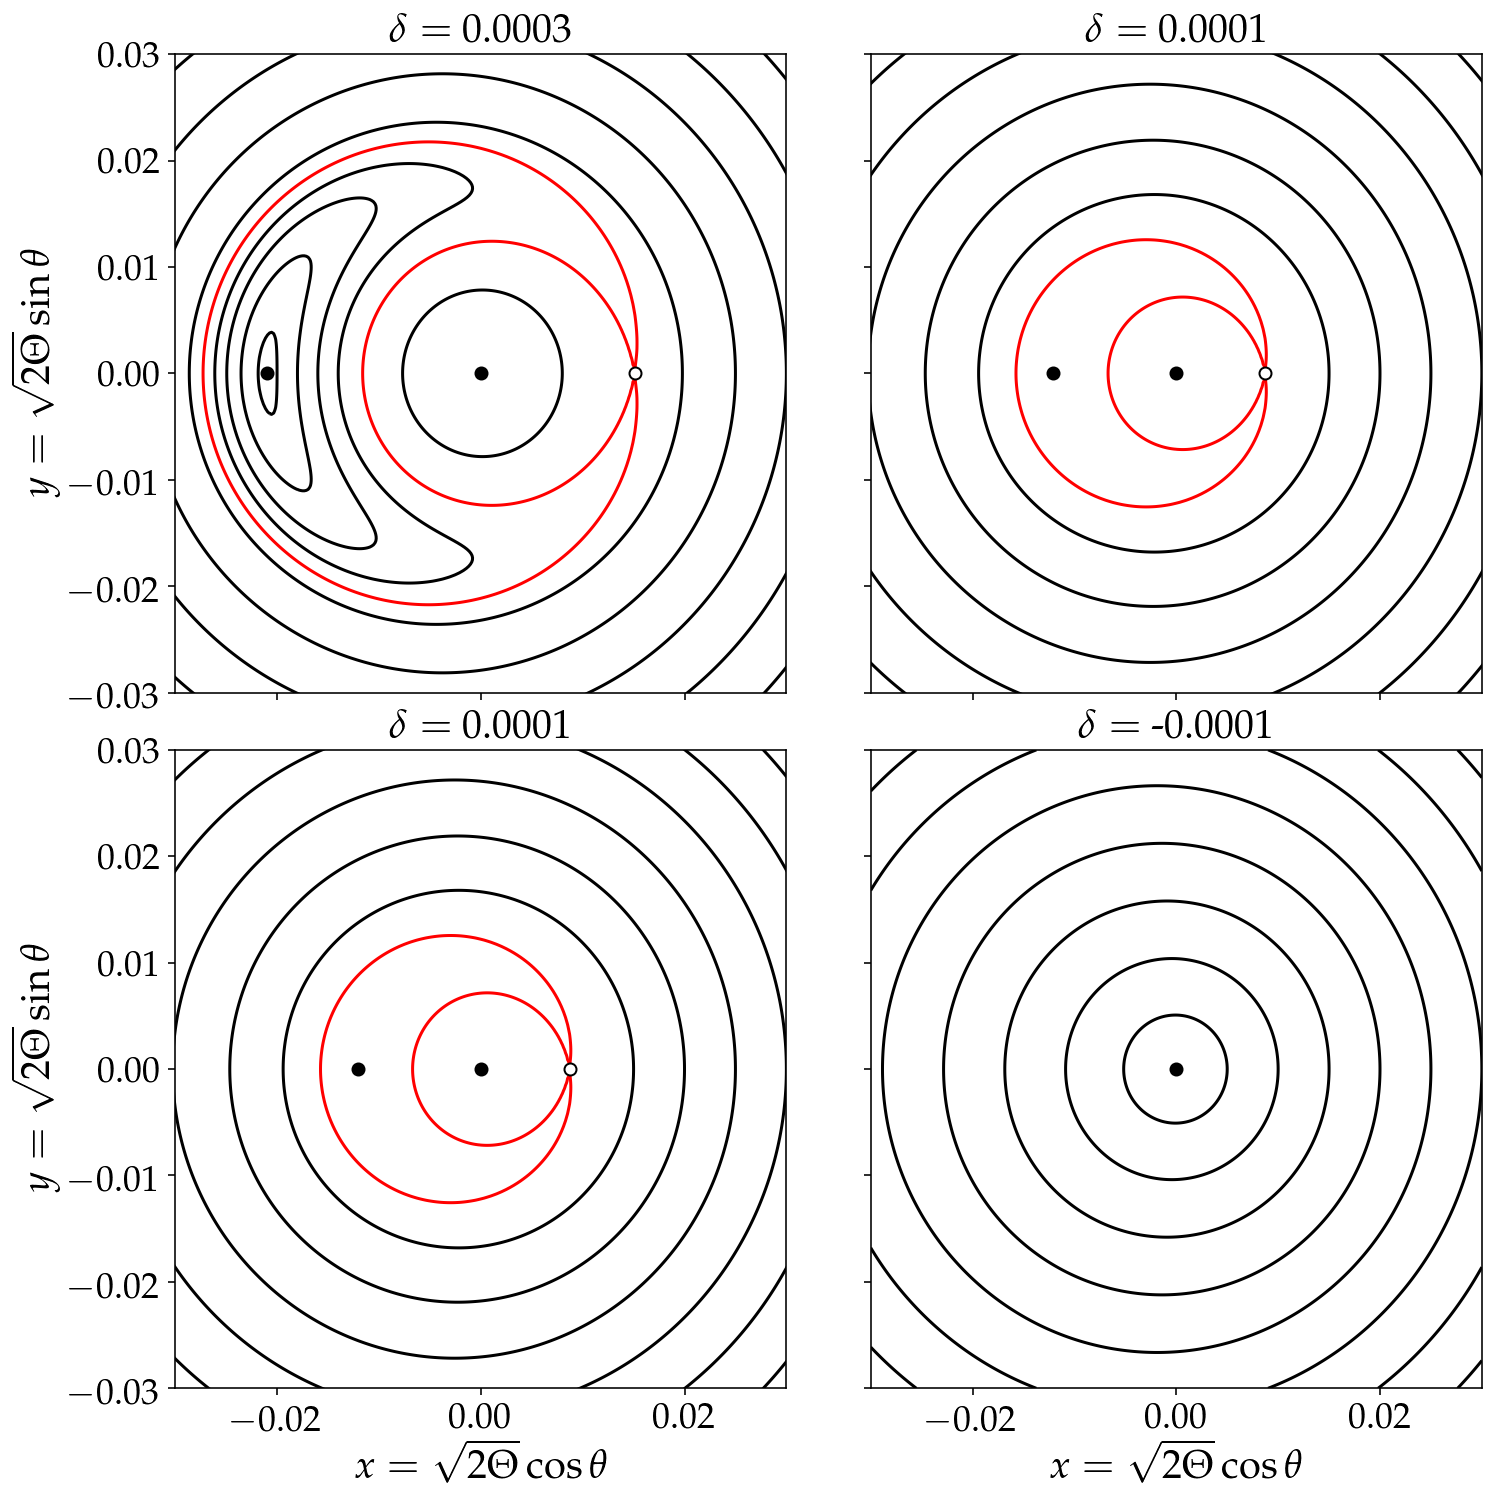

In [26]:
x_value = np.array([0.025, 0.03, 0.04, 0.05, 0.035, -0.014, -0.016, -0.018, -0.02, 0.008])

x_value2 = np.array([0.05, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015])
x_value3 = np.array([0.05, 0.045, 0.04, 0.035, 0.03, 0.02, 0.025, 0.015,
                    0.01, 0.005])


lvls = np.sort(H_cart(x_value, 0, 3e-04, 0.1))
lvls2 = np.sort(H_cart(x_value2, 0, 1e-04, 0.1))
lvls3 = np.sort(H_cart(x_value3, 0, -1e-04, 0.1))

fig, ax = plt.subplots(2, 2, sharex=True,sharey=True, figsize=(10, 10))
fig.tight_layout()
plot_hamiltonian(ax[0,0], 3e-04, 0.1, lvls)
plot_hamiltonian(ax[0,1], 1e-04, 0.1, lvls2)
plot_hamiltonian(ax[1,0], 1e-04, 0.1, lvls2)
plot_hamiltonian(ax[1,1], -1e-04, 0.1, lvls3)

for a in ax.ravel():
    a.set_xlim(-0.03, 0.03)
    a.set_ylim(-0.03, 0.03)

for a in ax[1,:]:
    a.set_xlabel(r'$x=\sqrt{2\Theta}\cos\theta$')
    
for a in ax[:,0]:
    a.set_ylabel(r'$y=\sqrt{2\Theta}\sin\theta$')

# plt.savefig('../figures/analytical_model/phase_space_plot_adiabatic.pdf', bbox_inches='tight')

## The Adiabatic invariant and the eccentricity kick

In order to estimate the eccentricity kick, we first need to calculate the area enclosed
by the inner and outer branches of the separatrix as a function of delta. We first solve for the roots of the separatrix equation as follows

$$\mathcal{H}_{sep}=\mathcal{H}\left( x_{saddle}\right)$$

This is the value of the Hamiltonian at the separatrix, the equation for the separatrix is then given by

$$\mathcal{H}_{sep}=\mathcal{H}(\Theta,\theta)$$

that is

In [27]:
H_saddle = symbols(r"\mathcal{H}_s", real=True)
separatrix_eq = Eq(H_saddle - ham)
separatrix_eq

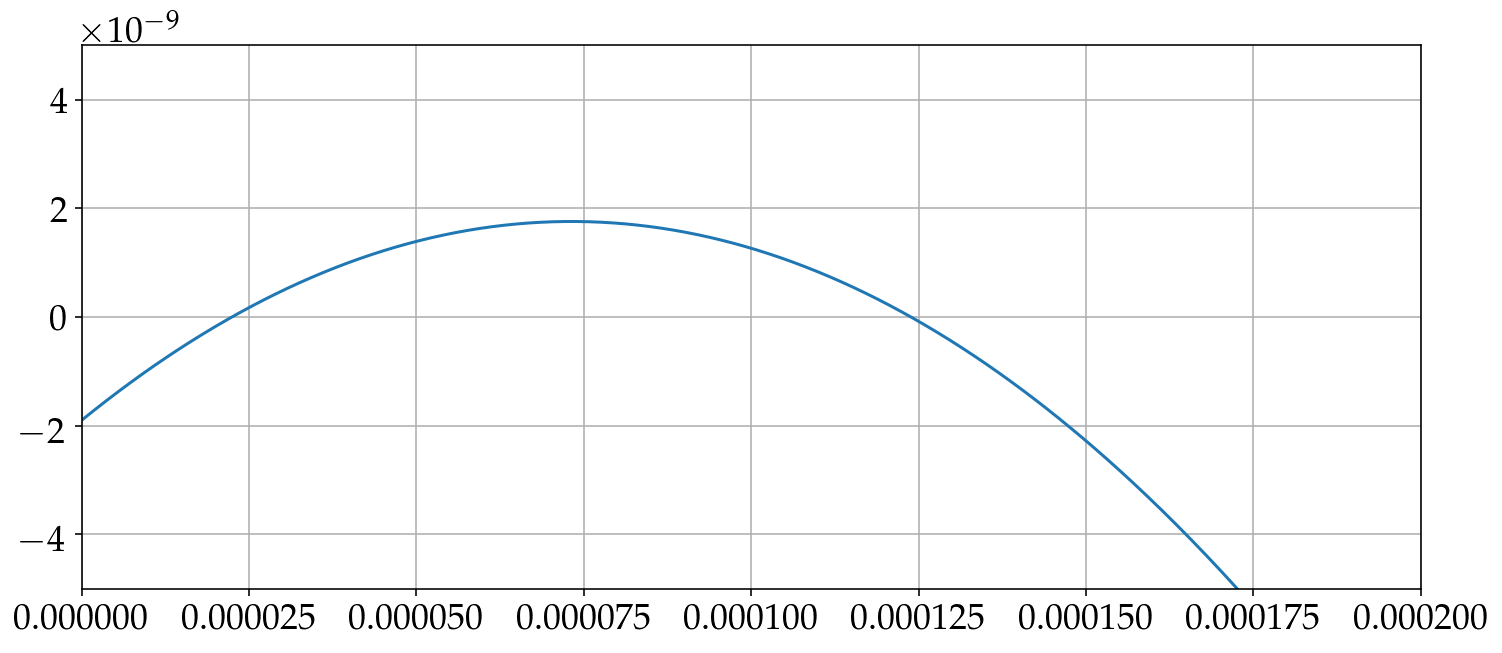

In [28]:
separatrix_roots = lambda Theta, c_, delta_, H_s: Theta**2*np.sqrt(Theta + c_)\
                        - Theta**2 + delta_*Theta + H_s

fig, ax = plt.subplots(figsize=(12,5))
Theta_ = np.linspace(0,0.03**2/2, 1000)
ax.plot(Theta_, separatrix_roots(Theta_, 0.1, 0.0001, -1.89928066014e-09))
ax.grid(True)
ax.set_xlim(0, 0.2e-3)
ax.set_ylim(-0.5e-08, 0.5e-08)

To find the limits of integration, we need to numerically solve for the value of $\Theta$ at $\theta=\pi$. As
seen from the figure, we expect to find two roots.

In [29]:
def func(Theta, *args):
    delta_, c_, H_s = args
    return Theta**2*np.sqrt(Theta + c_) - Theta**2 + delta_*Theta + H_s

from scipy.optimize import fsolve

x0 = fsolve(func, 0.0, (0.0001, 0.1,-1.89928066014e-09))
x1 = fsolve(func, 100*x0[0], (0.0001, 0.1,-1.89928066014e-09))

print(x0, x1)

[  2.24339232e-05] [ 0.00012386]


The action of a Hamiltonian system is defined by:

$$J=\oint \Phi\, d\phi$$

which is simply the area enclosed by a level curve. To calculate the actions associated 
with the inner and outer branches of the separatrix, we make use of the Hamilton's equations to switch the integration variable to $\phi$.

$$d\phi = \frac{\dot{\phi}}{\dot{\Phi}}d\Phi$$

therefore

$$J=\oint \Phi\frac{\dot{\phi}}{\dot{\Phi}}d\Phi$$

equivalently, in cartesian coordinates

$$J=\oint x\, dy$$

or

$$J=\oint x\frac{\dot{y}}{\dot{x}}dx$$

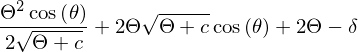

In [30]:
diff(ham, Theta)

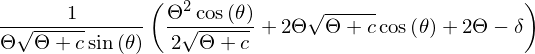

In [31]:
integrand = -Theta*diff(ham, Theta)/diff(ham, theta)
integrand

To solve the integral, we need to solve for $\cos (4\phi)$ and $\sin (4\phi)$ in terms of $\Phi$ and $\mathcal{H}_{sep}$. To do this, we make use of the equation for separatrix, in $(\Phi,\phi)$ coordinates.

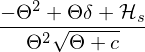

In [32]:
costheta = solve(separatrix_eq, cos(theta))[0]
costheta

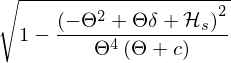

In [33]:
sintheta = sqrt(1 - costheta**2)
sintheta

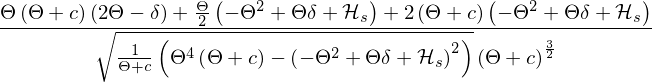

In [34]:
integrand = integrand.subs({
    cos(theta): costheta,
    sin(theta): sintheta
})
integrand = simplify(integrand)
integrand

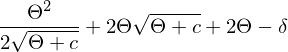

In [36]:
diff(ham, Theta).subs({theta:0})

In [37]:
ham

In [38]:
import scipy.integrate as integrate

def saddle_point_eq(Theta_, *args):
    delta_, c_ = args
    return Theta_**2/(2*np.sqrt(Theta_ + c_))\
    + 2*Theta_*np.sqrt(Theta_ + c_) + 2*Theta_ - delta_

H = lambda Theta_, theta_, delta_, c_: Theta_**2 - delta_*Theta_\
    + Theta_**2*np.sqrt(Theta_ + c_)*np.cos(theta_)
    
def separatrix_zeros_eq(Theta_, *args):
    delta_, c_, H_s = args
    return Theta_**2*np.sqrt(Theta_ + c_) - Theta_**2 + delta_*Theta_ + H_s    

# def integral(upp_limit, lower_limit, delta_, c_, H_s):
    
def f(T, *args):
    delta_, c_, H_s = args
    return (T*np.sqrt(T+c_)*(-T**2+delta_*T+H_s)/2+T*np.sqrt(T+c_)\
     *(T+c_)*(2*T-delta_)+2*np.sqrt(T+c_)*(T+c_)*(-T**2+T*delta_+H_s))\
    /(np.sqrt((T**4*(T+c_)-(-T**2+delta_*T+H_s)**2)/(T+c_))*(T+c_)**2)  
    
    
def A_inner(delta_, c_):
    # Calculate value position of saddle point
    T_saddle = fsolve(saddle_point_eq, 0.01, (delta_, c_))[0]
    
    if not (T_saddle > 0):
        print("Could not converge to a solution for Theta saddle")
    
    # Calculate value of H at saddle point
    print("T saddle", T_saddle)
    H_saddle = H(T_saddle, 0, delta_, c_)
    
    print("H saddle", H_saddle)
    
    # Calculate value of separatrix for theta=pi, inner branch
    T_inner= fsolve(separatrix_zeros_eq, 0.0, (delta_, c_, H_saddle))[0]
    T_outer= fsolve(separatrix_zeros_eq, 100*T_inner, (delta_, c_, H_saddle))[0]
    
    A_inner = integrate.quad(f, T_saddle, T_inner, (delta_, c_, H_saddle))
    A_outer = integrate.quad(f, T_saddle, T_outer, (delta_, c_, H_saddle))

    print(A_inner[0]/A_outer[0])

A_inner(0.0001, 0.1)

T saddle 3.79847468091e-05
H saddle -1.89928066014e-09
0.34438940636424314


# Calculate eccentricity kick

We start with a circle in the phase plane, the initial action is given by

$$A_{initial}=2\pi\Phi_{initial}=\frac{\pi}{2}\Gamma_o=
\frac{\pi}{2}\Lambda_o\left(1-\sqrt{1 - e_o^2}\right)$$

The area enclosed by the inner separatrix branch is given by

In [ ]:
A_inner_branch = lambda delta, eps: (delta/sqrt(1 - 16*eps**2))*\
    (acos((12*eps - 1)/(1 + 4*eps)) - pi*16*eps**2)
    
A_outer_branch = lambda delta, eps: delta/sqrt(1 - 16*eps**2)*\
    (pi*(2 - 16*eps**2) - acos((12*eps - 1)/(1 + 4*eps)))

A_inner_branch(delta, eps)

The area enclosed by the inner branch and the inital action define a value of $\delta$ 
called $\delta_t$ at which the initial action equals the inner separatrix action.

In [ ]:
A_initial, A_final = symbols(r'\mathcal{A}_{initial} \mathcal{A}_{final}', real=True)
delta_transition = solve(A_inner_branch(delta, eps) - A_initial, delta)
delta_transition[0]

The area of enclosed by the outer branch of the separatrix at $\delta=\delta_t$ is then
equal to

In [ ]:
final_action = simplify(A_outer_branch(delta_transition[0], eps))
final_action

We can solve for the ratio between those actions

In [ ]:
action_ratio = simplify(final_action/A_initial)
action_ratio

Therefore, we have

$$\frac{\mathcal{A}_{final}}{\mathcal{A}_{inital}}=\frac{2 \pi \left(8 \epsilon^{2} - 1\right) + \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right )}}{16 \pi \epsilon^{2} - \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right )}}=\frac{\Gamma_{o,final}}{\Gamma_{o,initial}}=\left(\frac{P_{o,final}}{P_{o,init}}\right)^{1/3}
\frac{1 - \sqrt{1 - e_{o,final}^2}}{1 - \sqrt{1 - e_{o, initial}^2}}$$
and the final eccentricity is

$$e_{o,final}^2=1 - \left(1 - \left(1 - \sqrt{1 - e_{o, initial}}\right) \frac{2 \pi \left(8 \epsilon^{2} - 1\right) + \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right)}}{16 \pi \epsilon^{2} - \operatorname{acos}{\left (\frac{12 \epsilon - 1}{4 \epsilon + 1} \right)}}\right)^2$$

the kick in eccentricity depends only on the initial eccenetricity and $\epsilon$.

In [ ]:
e_o_init, e_o_final = symbols(r'e_i, e_f', real=True, positive=True)

equation = Eq(action_ratio - (1 - sqrt(1 - e_o_final**2))/(1 - sqrt(1 - e_o_init**2)))
equation

In [ ]:
simplify(solve(equation, e_o_final**2))

In [ ]:
ratio = lambda eps: (2*np.pi*(8*eps**2 - 1) + np.arccos((12*eps - 1)/(4*eps + 1)))\
                     /(16*np.pi*eps**2 - np.arccos((12*eps - 1)/(4*eps + 1)))
                     
final_ecc = lambda eps, e_init: np.sqrt(1 - (1 - (1 - np.sqrt(1 - e_init))*ratio(eps))**2)
            
ecc_init = 0.01
final_ecc(0.03, ecc_init)